# Comparison of CALFIRE to FPA FOD 
CALFIRE is more current
### Attach packages, source code, etc.

In [2]:
library(dplyr)
library(readr)
library(ggplot2)
library(leaflet)
library(usmap)
library(ggmap)
library(sp)
library(sf)
library(viridis)
library(ggpubr)
library(maps)
library(spatstat)
fig <- function(width, heigth){
 options(repr.plot.width = width, repr.plot.height = heigth)
 }

In [3]:
fpa_fod <- suppressMessages(read_csv('/Users/rebeccawillison/Documents/research/wildfire/wildfires/data/ca_fires.csv', 
                    guess_max = 100000)) %>% dplyr::filter(!(FIRE_SIZE_CLASS %in% c('A','B')))
calfire <- suppressMessages(read_csv('/Users/rebeccawillison/Documents/research/wildfire/wildfires/data/mapdataall.csv')) %>%
                    dplyr::mutate(FIRE_YEAR = format(incident_date_created, '%Y'))

In [5]:
### get california state boundary for point process window
states <- st_as_sf(maps::map("state", plot = FALSE, fill = TRUE))
california <- as_Spatial(subset(states, grepl("california", states$ID)))
cal_poly <- fortify(california) %>% arrange(-order)
cal_window <- owin(poly = list(x = cal_poly$long[-1],
                               y = cal_poly$lat[-1]))

Regions defined for each Polygons



In [12]:
table(fpa_fod$FIRE_YEAR)
table(calfire$FIRE_YEAR)


1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 
 854  756  771  666  979  591  526  701  420  568  605  659  592  627  719  632 
2008 2009 2010 2011 2012 2013 2014 2015 
 707  406  364  520  443  503  294  396 


1969 2009 2013 2014 2015 2016 2017 2018 2019 2020 
   2    1  141   76   99  155  429  303  263  261 

In [8]:
head(calfire)

incident_name,incident_is_final,incident_date_last_update,incident_date_created,incident_administrative_unit,incident_administrative_unit_url,incident_county,incident_location,incident_acres_burned,incident_containment,⋯,incident_latitude,incident_type,incident_id,incident_url,incident_date_extinguished,incident_dateonly_extinguished,incident_dateonly_created,is_active,calfire_incident,notification_desired
<chr>,<lgl>,<dttm>,<dttm>,<chr>,<lgl>,<chr>,<chr>,<dbl>,<dbl>,⋯,<dbl>,<chr>,<chr>,<chr>,<dttm>,<date>,<date>,<chr>,<lgl>,<lgl>
Bridge Fire,TRUE,2018-01-09 13:46:00,2017-10-31 11:22:00,Shasta-Trinity National Forest,NA,Shasta,"I-5 and Turntable Bay, 7 miles NE of Shasta Lake",37,100,⋯,40.77400,NA,2ca11d45-8139-4c16-8af0-880d99b21e82,https://www.fire.ca.gov/incidents/2017/10/31/bridge-fire/,2018-01-09 13:46:00,2018-01-09,2017-10-31,N,FALSE,FALSE
Pala Fire,TRUE,2020-09-16 14:07:35,2009-05-24 14:56:00,CAL FIRE San Diego Unit,NA,San Diego,"Hwy 76 and Pala Temecula, northwest of Pala",122,100,⋯,1.00000,Wildfire,8f61f461-552d-4538-b186-35ab030da416,https://www.fire.ca.gov/incidents/2009/5/24/pala-fire/,2009-05-25 00:00:00,2009-05-25,2009-05-24,N,TRUE,FALSE
River Fire,TRUE,2013-02-28 20:00:00,2013-02-24 08:16:00,CAL FIRE San Bernardino Unit,NA,Inyo,"south of Narrow Gauge Rd & north of Hwy 136, east of Lone Pine",406,100,⋯,36.60258,NA,094719ba-a47b-4abb-9ec5-a506b2b9fd23,https://www.fire.ca.gov/incidents/2013/2/24/river-fire/,2013-02-28 20:00:00,2013-02-28,2013-02-24,N,TRUE,FALSE
Fawnskin Fire,TRUE,2013-04-22 09:00:00,2013-04-20 17:30:00,San Bernardino National Forest,NA,San Bernardino,"west of Delamar Mountain, north of the community of Fawnskin, northside of Big Bear Lake",30,100,⋯,34.28888,NA,58f89ff8-bd3e-4355-b1c0-8fa05c747d3f,https://www.fire.ca.gov/incidents/2013/4/20/fawnskin-fire/,2013-04-22 09:00:00,2013-04-22,2013-04-20,N,FALSE,FALSE
Gold Fire,TRUE,2013-05-01 07:00:00,2013-04-30 12:59:00,CAL FIRE Madera-Mariposa-Merced Unit,NA,Madera,Between Road 210 and Road 200 near Fine Gold Creek in the community of O,274,100,⋯,37.11630,NA,357ffc13-bef9-48eb-810f-c5de851972eb,https://www.fire.ca.gov/incidents/2013/4/30/gold-fire/,2013-05-01 07:00:00,2013-05-01,2013-04-30,N,TRUE,FALSE
Panther Fire,TRUE,2013-05-09 09:00:00,2013-05-01 09:12:00,CAL FIRE Butte Unit,NA,Tehama,"140K3 Line, 8 miles northwest of Butte Meadows",6965,100,⋯,40.19006,NA,53122f0f-fefc-4dbf-b2d8-566b42ced66d,https://www.fire.ca.gov/incidents/2013/5/1/panther-fire/,2013-05-09 09:00:00,2013-05-09,2013-05-01,N,TRUE,FALSE


In [37]:
plot_wildfire_intensity <- function(source, year){
    if(source == 'calfire'){
        cal_df <- calfire %>% 
            dplyr::mutate(inCalifornia = point.in.polygon(incident_longitude, incident_latitude, 
                                                          california@polygons[[1]]@Polygons[[1]]@coords[,1],
                                                          california@polygons[[1]]@Polygons[[1]]@coords[,2])) %>%
            dplyr::filter(FIRE_YEAR == year, inCalifornia == 1) 
        cal_pp <- suppressWarnings(ppp(cal_df$incident_longitude, cal_df$incident_latitude, window = cal_window))
    }else{
        cal_df <- fpa_fod %>%
            dplyr::mutate(inCalifornia = point.in.polygon(LONGITUDE, LATITUDE, 
                                                          california@polygons[[1]]@Polygons[[1]]@coords[,1],
                                                          california@polygons[[1]]@Polygons[[1]]@coords[,2])) %>%
            dplyr::filter(FIRE_YEAR == year, inCalifornia == 1) 
        cal_pp <- suppressWarnings(ppp(cal_df$LONGITUDE, cal_df$LATITUDE, window = cal_window))
        
    }
    plot(density(cal_pp), main = paste(source, year, '\nN =', cal_pp$n))
}

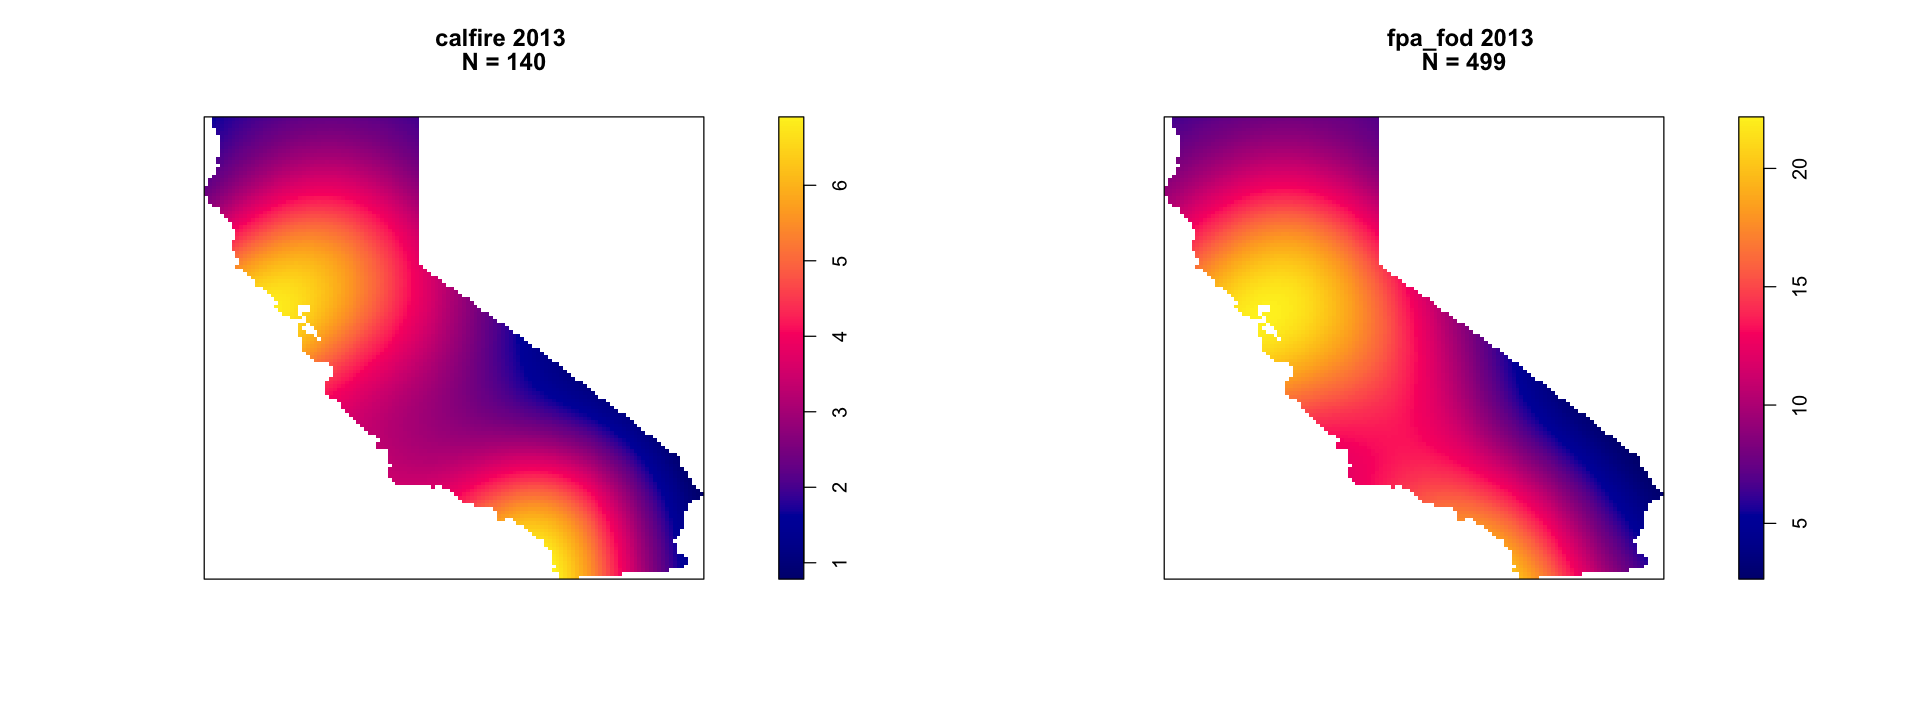

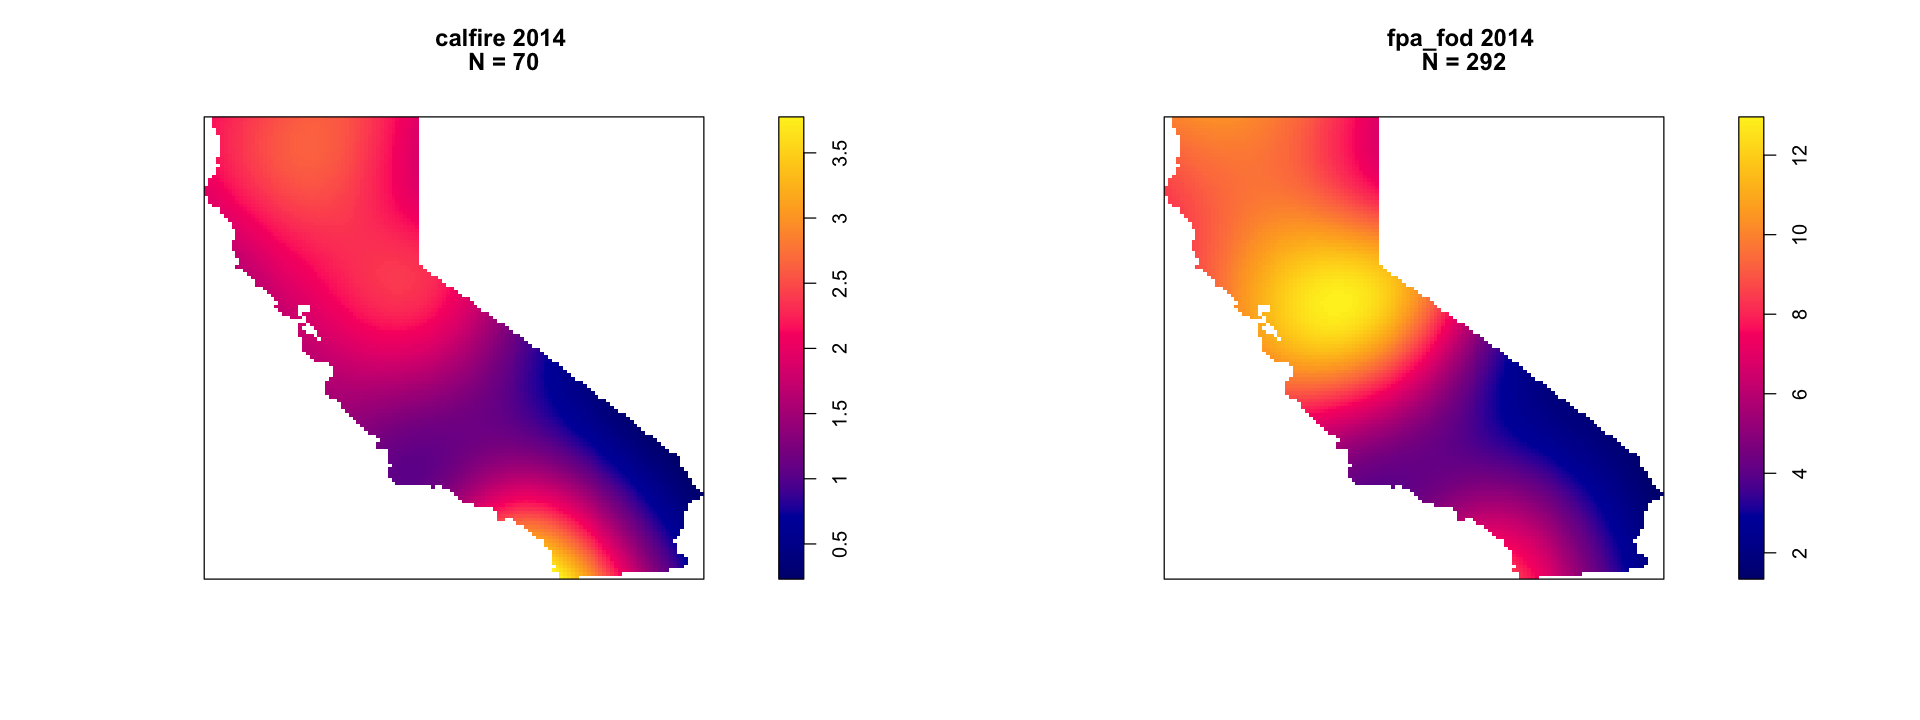

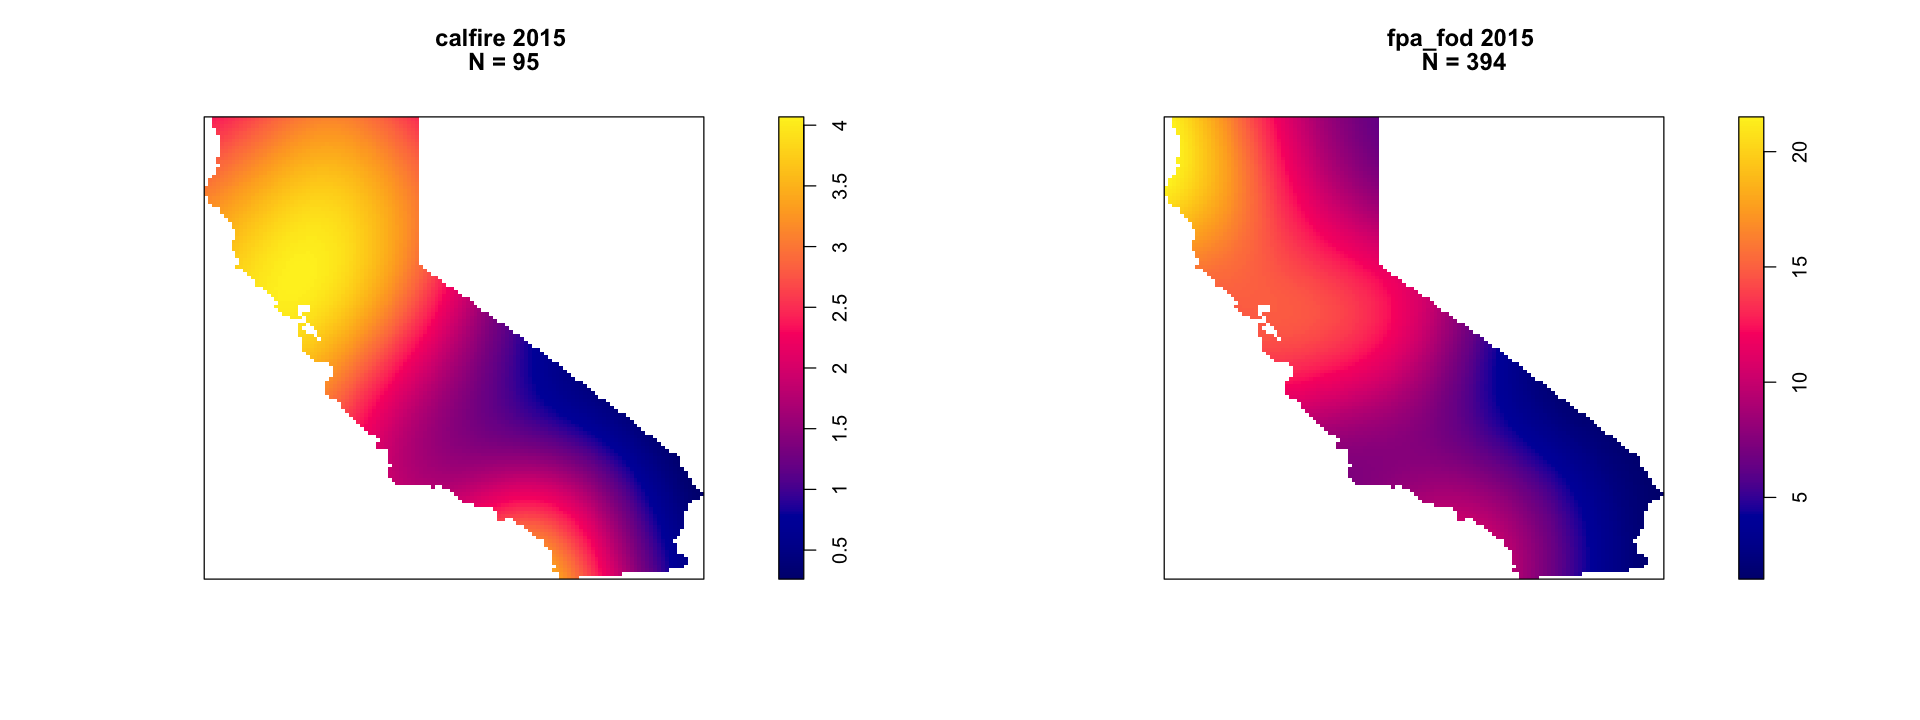

In [38]:
fig(16, 6)
par(mfrow = c(1, 2))
for(y in 2013:2015){
    plot_wildfire_intensity('calfire', as.character(y))
    plot_wildfire_intensity('fpa_fod', as.character(y))
}